In [2]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [3]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:53<00:00,  2.36it/s]


In [4]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [5]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [6]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [7]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ATERNAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
code2prompts

defaultdict(list,
            {'0031c86e-81f4-4eef-9e0e-28037abf9883': ["Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. ",
              'Provide Python code to understand a dataset using Pandas. Find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.',
              "You will preprocess the data now1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing2. Encode labels with mappings using the map function. Mapping names:    - sex_map = {'female': 1, 'male': 0}   - island_map = {'Biscoe': 1, 'Dr

In [9]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.329383,-0.088851,-0.115244,-0.090640,0.234883,0.062204,0.045172,0.335716,0.135970,0.055337,...,-0.252690,-0.094181,-0.125706,-0.111531,0.155526,-0.042543,0.058645,-0.149229,-0.001281,-0.211996
1,0.604796,-0.163057,-0.096221,-0.130001,0.435961,-0.118038,-0.148960,0.437375,0.239906,0.001119,...,-0.171837,-0.159496,-0.158047,-0.179293,0.376396,0.136014,0.149402,-0.114761,0.073524,-0.096295
2,0.288137,0.072770,0.059443,-0.281316,0.252693,-0.037200,0.012099,0.494654,-0.092840,0.435456,...,-0.561254,-0.063745,-0.124195,0.060418,0.105365,0.094710,-0.106741,-0.184995,-0.108021,-0.004349
3,0.243231,-0.009798,0.200366,0.112232,0.082252,-0.079794,0.286173,0.576961,-0.108414,0.169706,...,-0.250866,-0.008101,0.081456,-0.163640,0.295160,0.230064,-0.286787,-0.377600,-0.104784,-0.329142
4,0.439418,-0.108228,-0.162366,-0.124093,0.347573,-0.031413,-0.148867,0.298411,0.181094,0.002279,...,-0.195682,-0.144516,-0.148568,-0.113715,0.398988,0.182057,0.110023,-0.173732,-0.021078,-0.164921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.449306,-0.047352,-0.304087,-0.222618,0.394005,0.142379,-0.028801,0.496889,0.136117,-0.124183,...,-0.065661,0.025565,-0.167570,-0.097232,-0.013843,0.090903,0.330449,-0.138649,-0.019247,-0.054956
60,0.587004,-0.103320,-0.043811,-0.001228,0.029493,-0.064117,0.242966,0.400723,-0.141990,-0.100350,...,-0.091599,0.263272,-0.022328,-0.106502,0.294637,0.070199,0.002032,0.391283,0.133663,0.025115
61,0.467420,-0.204724,0.067410,-0.217140,0.257099,-0.186230,0.246516,0.614882,-0.100950,-0.057506,...,-0.355396,0.027783,-0.153777,-0.230372,0.340944,0.092170,-0.037162,0.179188,-0.053349,-0.023441
62,0.535715,-0.253196,-0.018501,-0.287898,0.322428,0.100336,-0.115582,0.602067,0.145737,0.056898,...,-0.313234,-0.046444,-0.045744,-0.045098,0.221145,0.063734,0.099949,-0.046607,0.031067,-0.080398


In [11]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.310292,-0.101257,-0.088082,-0.132355,0.272140,0.069301,-0.121608,0.297051,0.072009,0.094004,...,-0.229255,-0.048551,-0.124246,-0.066938,0.179872,0.082411,0.106819,-0.209148,-0.097164,-0.176040
1,0.367014,-0.049092,-0.132772,-0.096899,0.314777,0.078059,0.006507,0.347334,0.149709,0.070939,...,-0.278902,-0.051092,-0.162821,-0.111985,0.237026,0.217585,0.073553,-0.216457,0.042391,-0.237048
2,0.242311,0.006410,0.056797,-0.096210,0.207020,-0.049327,-0.048291,0.422735,-0.051843,0.240705,...,-0.310637,0.045134,0.038206,0.097520,0.063406,0.048921,-0.082399,-0.193587,-0.068038,-0.050502
3,0.196160,-0.064634,0.095160,-0.127508,0.079032,0.073913,0.132788,0.446792,-0.050835,0.169074,...,-0.420159,0.006994,-0.224207,-0.138187,0.046216,-0.160989,-0.056404,-0.066019,0.219983,-0.202299
4,0.361422,-0.045618,-0.192077,0.005825,0.141678,0.107454,0.108990,0.382223,0.001832,-0.144521,...,-0.102481,-0.037827,-0.121381,-0.127611,0.238918,0.155352,0.022240,-0.124166,0.162302,-0.145737
5,0.302659,-0.044960,-0.302086,-0.112992,0.219745,0.210794,0.111491,0.492906,0.081405,-0.117080,...,-0.161969,0.039813,-0.194452,-0.112197,0.176795,0.116597,0.171115,-0.168307,-0.009108,-0.267523
6,0.398981,-0.085011,-0.117072,-0.076452,0.226340,0.045067,0.069745,0.487786,0.040669,-0.009856,...,-0.143298,0.075076,-0.047982,-0.089654,0.201785,0.117214,0.113872,-0.031434,-0.050515,-0.147114
7,0.587549,-0.364339,-0.007200,-0.343239,0.335789,0.081084,-0.183592,0.827465,0.126348,0.046311,...,-0.414928,-0.037773,-0.029913,-0.020946,0.332341,-0.068762,0.050262,-0.051366,-0.022825,-0.185897


In [12]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [13]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.956296,0.951411,0.887000,0.956605,0.934641,0.915927,0.931350,0.840666
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.959393,0.956969,0.988737,0.951423,0.999673,0.968938,0.930339,0.983406
2,041f950b-c013-409a-a642-cffff60b9d4b,0.947442,0.964662,0.789458,0.936199,0.895661,0.917824,0.964855,0.794600
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.865629,0.884647,0.861928,0.888422,0.931673,0.883859,0.918815,0.964241
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.948085,0.950945,0.960682,0.949146,0.986751,0.970690,0.991127,0.977756
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.934162,0.944588,0.838474,0.893175,0.932013,0.999122,0.998527,0.988651
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.910750,0.945602,0.996799,0.992312,0.991077,0.938199,0.992965,0.970787
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.983147,0.999349,0.996836,0.999524,0.999469,0.998388,0.999157,0.979574
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.979819,0.993858,0.957761,0.999658,0.986797,1.000000,1.000001,0.938337


In [14]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [15]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF

,00000,000000,000000diet,000000flipper_length_mm,000000life_stage,000000name,000000year,000196,000196diet,000282island,...,yx,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [17]:
print(code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape)
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

(86, 6495)


,00000,000000,000000diet,000000flipper_length_mm,000000life_stage,000000name,000000year,000196,000196diet,000282island,...,yx,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [19]:
questions[0]

'Load training dataset\n    *  Read the .csv file with the pandas library\n'

In [20]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores_tf_idf = pd.DataFrame(code2questionmapping).T
question_mapping_scores_tf_idf.reset_index(inplace=True)
question_mapping_scores_tf_idf.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_tf_idf.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_tf_idf

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.304079,0.536070,0.368903,0.504798,0.577103,0.181440,0.188972,0.217575
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.823039,0.786561,0.891001,0.678520,0.972643,0.790169,0.560439,0.609047
2,041f950b-c013-409a-a642-cffff60b9d4b,0.260152,0.611201,0.326975,0.649491,0.431308,0.509783,0.513320,0.287194
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.122250,0.270359,0.320293,0.367270,0.320677,0.207892,0.286513,0.456046
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.595014,0.797634,0.646773,0.738703,0.864109,0.623336,0.892093,0.573190
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.153030,0.298647,0.215979,0.157421,0.516581,0.927496,0.765982,0.750481
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.123868,0.277965,0.959469,0.857600,0.859482,0.284532,0.853966,0.619669
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.938918,0.972892,0.930543,0.992783,0.956679,0.840114,0.837490,0.559604
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1.000000,0.977436,0.703321,0.949386,0.849035,0.927496,0.915792,0.745384


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [21]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy","how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [22]:
df_tf_idf = pd.DataFrame(code2features).T
df_word2vec = pd.DataFrame(code2features).T
df_word2vec.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913


In [23]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


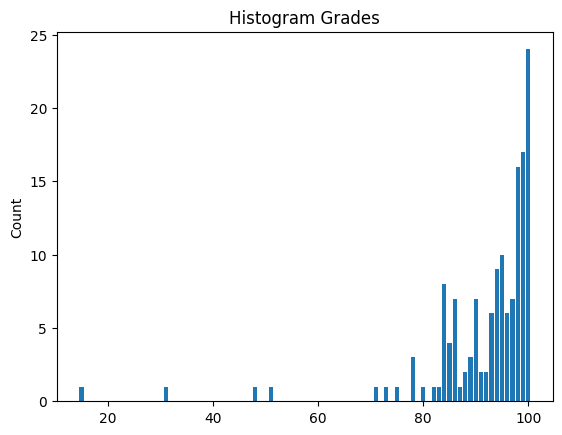

In [24]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [25]:
df_tf_idf.reset_index(inplace=True, drop=False)
df_tf_idf.rename(columns={"index": "code"}, inplace=True)

df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_tf_idf.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913


In [26]:
df_tf_idf = pd.merge(df_tf_idf, question_mapping_scores_tf_idf, on="code", how="left")
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370,0.956296,0.951411,0.887000,0.956605,0.934641,0.915927,0.931350,0.840666
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582,0.959393,0.956969,0.988737,0.951423,0.999673,0.968938,0.930339,0.983406
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601,0.947442,0.964662,0.789458,0.936199,0.895661,0.917824,0.964855,0.794600
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566,0.865629,0.884647,0.861928,0.888422,0.931673,0.883859,0.918815,0.964241
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913,0.948085,0.950945,0.960682,0.949146,0.986751,0.970690,0.991127,0.977756


#### Merging scores with features

In [27]:
temp_df_tf_idf = pd.merge(df_tf_idf, scores, on='code', how="left")
temp_df_tf_idf.dropna(inplace=True)
temp_df_tf_idf.drop_duplicates("code",inplace=True, keep="first")

temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")



temp_df_tf_idf.head()
temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370,0.956296,0.951411,0.887000,0.956605,0.934641,0.915927,0.931350,0.840666,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582,0.959393,0.956969,0.988737,0.951423,0.999673,0.968938,0.930339,0.983406,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601,0.947442,0.964662,0.789458,0.936199,0.895661,0.917824,0.964855,0.794600,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566,0.865629,0.884647,0.861928,0.888422,0.931673,0.883859,0.918815,0.964241,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913,0.948085,0.950945,0.960682,0.949146,0.986751,0.970690,0.991127,0.977756,100.0


In [28]:
X_tf_idf = temp_df_tf_idf[temp_df_tf_idf.columns[1:-1]].to_numpy()
y_tf_idf = temp_df_tf_idf["grade"].to_numpy()

X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()


print(X_tf_idf.shape, y_tf_idf.shape)
print(X_word2vec.shape, y_word2vec.shape)

(122, 17) (122,)
(122, 17) (122,)


#### Train/Test split

In [29]:
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y_tf_idf, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_tf_idf))
print("Test set size:", len(X_test_tf_idf))

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


In [30]:
def get_class_dist(class_counts):
  class_0_count = class_counts[0]
  class_1_count = class_counts[1]
  class_0_ratio = class_0_count / (class_0_count + class_1_count)
  print(f"Class 0 count: {class_0_count}")
  print(f"Class 1 count: {class_1_count}")
  print(f"Class 0 ratio: {class_0_ratio:.3f}")

In [31]:
# Exploring train and test class distribution
print('Training data:')
class_counts = pd.Series(y_train_word2vec).value_counts()
#get_class_dist(class_counts)

print()

print('Test data:')
class_counts = pd.Series(y_test_word2vec).value_counts()
#get_class_dist(class_counts)


Training data:

Test data:


#### Fitting a model

#### Predicting and Analyzing

In [32]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train_tf_idf, y_train_tf_idf)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [33]:
# Training the model
# First we create a full decision tree (we do not limit the depth by any hyperparameters)
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X_train_word2vec, y_train_word2vec)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [34]:
# Binary predictions
y_pred = model.predict(X_train_word2vec)
y_pred[:10]

array([100.,  51.,  96.,  94., 100.,  84., 100.,  94.,  97.,  85.])

In [35]:
# Class probabilities
y_prob = model.predict_proba(X_test_word2vec)
y_prob[:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [36]:
# How can we know which column refers to which class?
model.classes_

array([ 15.,  31.,  51.,  71.,  73.,  75.,  78.,  80.,  82.,  83.,  84.,
        85.,  86.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
        97.,  98.,  99., 100.])

In [37]:
# MODEL EVALUATION

from sklearn.metrics import classification_report


y_pred = model.predict(X_test_word2vec)

print(classification_report(y_test_word2vec, y_pred))

              precision    recall  f1-score   support

        15.0       0.00      0.00      0.00       0.0
        48.0       0.00      0.00      0.00       1.0
        51.0       0.00      0.00      0.00       0.0
        78.0       0.00      0.00      0.00       1.0
        82.0       0.00      0.00      0.00       0.0
        84.0       0.00      0.00      0.00       0.0
        86.0       0.00      0.00      0.00       2.0
        87.0       0.00      0.00      0.00       1.0
        88.0       0.00      0.00      0.00       1.0
        90.0       0.00      0.00      0.00       2.0
        91.0       0.00      0.00      0.00       1.0
        92.0       0.00      0.00      0.00       0.0
        93.0       0.00      0.00      0.00       0.0
        94.0       0.00      0.00      0.00       3.0
        95.0       0.00      0.00      0.00       1.0
        96.0       0.00      0.00      0.00       1.0
        97.0       0.00      0.00      0.00       3.0
        98.0       0.00    

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Rec

In [38]:
# Macro-avg and weighted-avg
from sklearn.metrics import f1_score

"""
score_0 = f1_score(y_pred, y_test_word2vec, pos_label=0)
score_1 = f1_score(y_pred, y_test_word2vec, pos_label=1)

macro_avg = (score_0 + score_1) / 2
weighted_avg = (110*score_0 + 69*score_1) / (105 + 74)
print(f"Macro avg: {macro_avg:.3f} / Weighted avg: {weighted_avg:.3f}")
"""

# Assuming y_pred and y_test_word2vec are defined and are multiclass

# F1 Scores
f1_macro = f1_score(y_test_word2vec, y_pred, average='macro')
f1_weighted = f1_score(y_test_word2vec, y_pred, average='weighted')

print(f"Macro avg F1 score: {f1_macro:.3f}")
print(f"Weighted avg F1 score: {f1_weighted:.3f}")


Macro avg F1 score: 0.000
Weighted avg F1 score: 0.000


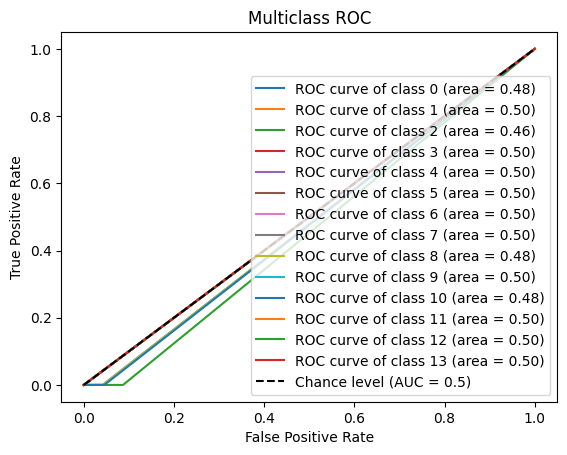

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test_word2vec, classes=np.unique(y_test_word2vec))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()


In [40]:
# What is the depth of the fitted tree?
model.get_depth()

8

In [41]:
from sklearn.model_selection import KFold, StratifiedKFold


# Assuming y_train_word2vec is your training dataset labels

# Get unique class labels and counts
class_counts = pd.Series(y_train_word2vec).value_counts()
unique_classes = class_counts.index.tolist()

print('Original data class distribution:')
for class_label in unique_classes:
    class_ratio = class_counts[class_label] / len(y_train_word2vec)
    print(f"Class {class_label} ratio in all training data = {class_ratio:.3f}")


Original data class distribution:
Class 100.0 ratio in all training data = 0.175
Class 99.0 ratio in all training data = 0.134
Class 98.0 ratio in all training data = 0.082
Class 95.0 ratio in all training data = 0.072
Class 96.0 ratio in all training data = 0.052
Class 94.0 ratio in all training data = 0.052
Class 84.0 ratio in all training data = 0.052
Class 93.0 ratio in all training data = 0.052
Class 90.0 ratio in all training data = 0.052
Class 97.0 ratio in all training data = 0.041
Class 86.0 ratio in all training data = 0.031
Class 89.0 ratio in all training data = 0.031
Class 85.0 ratio in all training data = 0.031
Class 92.0 ratio in all training data = 0.021
Class 83.0 ratio in all training data = 0.010
Class 51.0 ratio in all training data = 0.010
Class 75.0 ratio in all training data = 0.010
Class 88.0 ratio in all training data = 0.010
Class 80.0 ratio in all training data = 0.010
Class 82.0 ratio in all training data = 0.010
Class 91.0 ratio in all training data = 0.010

In [42]:
from sklearn.model_selection import StratifiedKFold

def get_class_dist(class_counts):
    total = sum(class_counts)
    for class_label in class_counts.index:
        print(f"Class {class_label} ratio: {class_counts[class_label] / total:.3f}")

skf = StratifiedKFold(n_splits=3)
for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    print(f'Split {i}:')
    print('Train:')
    class_counts = pd.Series(yt).value_counts()
    get_class_dist(class_counts)
    print('\nValidation:')
    class_counts = pd.Series(yv).value_counts()
    get_class_dist(class_counts)
    print('\n')


Split 0:
Train:
Class 100.0 ratio: 0.172
Class 99.0 ratio: 0.125
Class 98.0 ratio: 0.094
Class 84.0 ratio: 0.062
Class 95.0 ratio: 0.062
Class 96.0 ratio: 0.047
Class 90.0 ratio: 0.047
Class 93.0 ratio: 0.047
Class 94.0 ratio: 0.047
Class 85.0 ratio: 0.031
Class 89.0 ratio: 0.031
Class 97.0 ratio: 0.031
Class 86.0 ratio: 0.031
Class 73.0 ratio: 0.016
Class 71.0 ratio: 0.016
Class 78.0 ratio: 0.016
Class 51.0 ratio: 0.016
Class 91.0 ratio: 0.016
Class 88.0 ratio: 0.016
Class 82.0 ratio: 0.016
Class 80.0 ratio: 0.016
Class 75.0 ratio: 0.016
Class 83.0 ratio: 0.016
Class 92.0 ratio: 0.016

Validation:
Class 100.0 ratio: 0.182
Class 99.0 ratio: 0.152
Class 95.0 ratio: 0.091
Class 96.0 ratio: 0.061
Class 94.0 ratio: 0.061
Class 97.0 ratio: 0.061
Class 98.0 ratio: 0.061
Class 90.0 ratio: 0.061
Class 93.0 ratio: 0.061
Class 84.0 ratio: 0.030
Class 85.0 ratio: 0.030
Class 86.0 ratio: 0.030
Class 89.0 ratio: 0.030
Class 31.0 ratio: 0.030
Class 15.0 ratio: 0.030
Class 92.0 ratio: 0.030


Split 1

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [43]:
# Crating an array of different values of min_samples_split
from sklearn.metrics import accuracy_score


min_samples_split_arr = np.arange(2, 200, 4)

# Now we want to evaluate the decision tree model on all these values
# We loop through all min_samples_split values and conduct a cross validation
# evaluation for each min_samples_split value

# Arrays to save the average cross-validation scores for each min_samples_split value
# on the train and validation data of each split
train_score_arr = []
val_score_arr = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_score_arr = []
  fold_val_score_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    acc = accuracy_score(y_pred_train, yt)
    fold_train_score_arr.append(acc)

    # Validation
    acc = accuracy_score(y_pred_val, yv)
    fold_val_score_arr.append(acc)

  # After running all splits, we compute the avgof accuracies in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_score_arr)
  val_score_mean = np.mean(fold_val_score_arr)

  # Appending the avg/std scores of this min_samples_split value
  train_score_arr.append(train_score_mean)
  val_score_arr.append(val_score_mean)

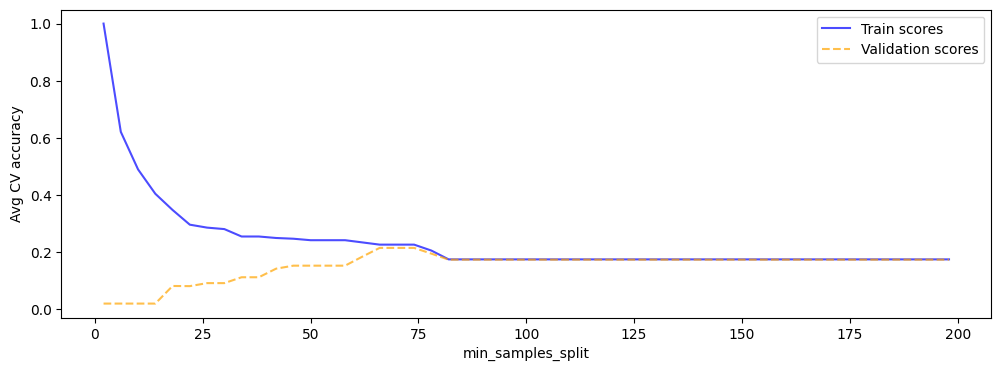

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(min_samples_split_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV accuracy')

plt.show()

In [45]:
# Crating an array of different values of max_depth
max_depth_arr = np.arange(1, 26)

# Now we want to evaluate the decision tree model on all these values
# We loop through all max_depth values and conduct a cross validation
# evaluation for each max_depth value

# Arrays to save the average cross-validation scores for each max_depth value
# on the train and validation data of each split
train_score_arr = []
val_score_arr = []
for max_depth in max_depth_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_score_arr = []
  fold_val_score_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    acc = accuracy_score(y_pred_train, yt)
    fold_train_score_arr.append(acc)

    # Validation
    acc = accuracy_score(y_pred_val, yv)
    fold_val_score_arr.append(acc)

  # After running all splits, we compute the avgof accuracies in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_score_arr)
  val_score_mean = np.mean(fold_val_score_arr)

  # Appending the avg/std scores of this max_depth value
  train_score_arr.append(train_score_mean)
  val_score_arr.append(val_score_mean)

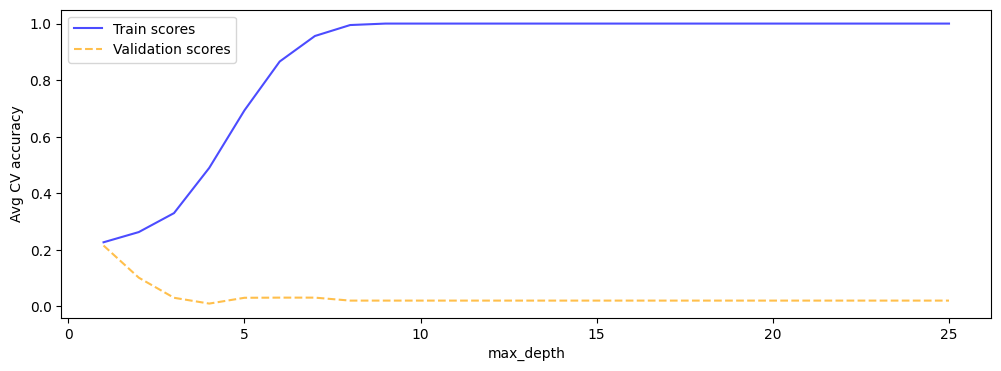

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(max_depth_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV accuracy')

plt.show()

In [47]:
from sklearn.model_selection import GridSearchCV

# param_grid represents the hyperparameters we want to try (our search space)
param_grid = {
    'max_depth': [5, 8, 12, 16],
    'min_samples_split': [4, 8, 14, 20]
}

# estimator is the model we are evaluating, Decision Tree in our case
estimator = DecisionTreeClassifier(criterion='entropy', random_state=42)

# scoring is the score used to choose the best model
scoring='f1_macro'

# cv is the number of folds to use for cross validation
cv = 5

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv)

In [48]:
# By calling the fit() method, it will automatically divide the
# training data into five folds and conduct cross-validation on
# these folds for each hyperparameter combination
grid_search.fit(X_train_word2vec, y_train_word2vec)

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': [5, 8, 12, 16],
                         'min_samples_split': [4, 8, 14, 20]},
             scoring='f1_macro')

In [49]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [50]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
5,8,8,0.054084,0.048449
9,12,8,0.054084,0.048449
13,16,8,0.054084,0.048449
1,5,8,0.053806,0.047964
4,8,4,0.051019,0.044551
8,12,4,0.051019,0.044551
12,16,4,0.051019,0.044551
2,5,14,0.044597,0.035491
6,8,14,0.044597,0.035491
10,12,14,0.044597,0.035491


In [51]:
# We use different values of these hyperparameters
model = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=8,
    min_samples_split=8
)

model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)

print(classification_report(y_test_word2vec, y_pred))

              precision    recall  f1-score   support

        48.0       0.00      0.00      0.00         1
        78.0       0.00      0.00      0.00         1
        84.0       0.00      0.00      0.00         0
        85.0       0.00      0.00      0.00         0
        86.0       0.00      0.00      0.00         2
        87.0       0.00      0.00      0.00         1
        88.0       0.00      0.00      0.00         1
        89.0       0.00      0.00      0.00         0
        90.0       0.00      0.00      0.00         2
        91.0       0.00      0.00      0.00         1
        94.0       0.33      0.33      0.33         3
        95.0       0.00      0.00      0.00         1
        96.0       0.00      0.00      0.00         1
        97.0       0.00      0.00      0.00         3
        98.0       0.00      0.00      0.00         2
        99.0       0.14      1.00      0.25         1
       100.0       0.00      0.00      0.00         5

    accuracy              

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Rec

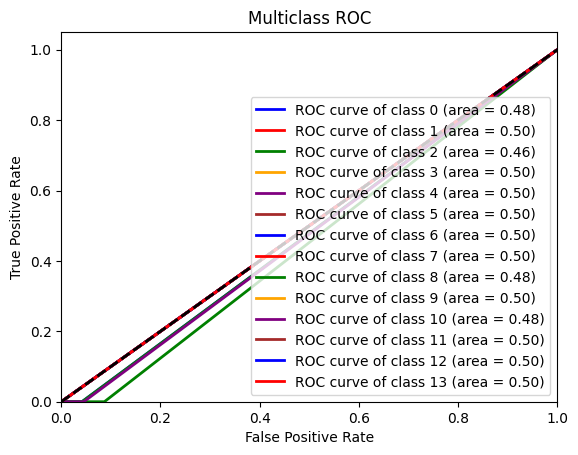

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
y_test_binarized = label_binarize(y_test_word2vec, classes=np.unique(y_test_word2vec))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()


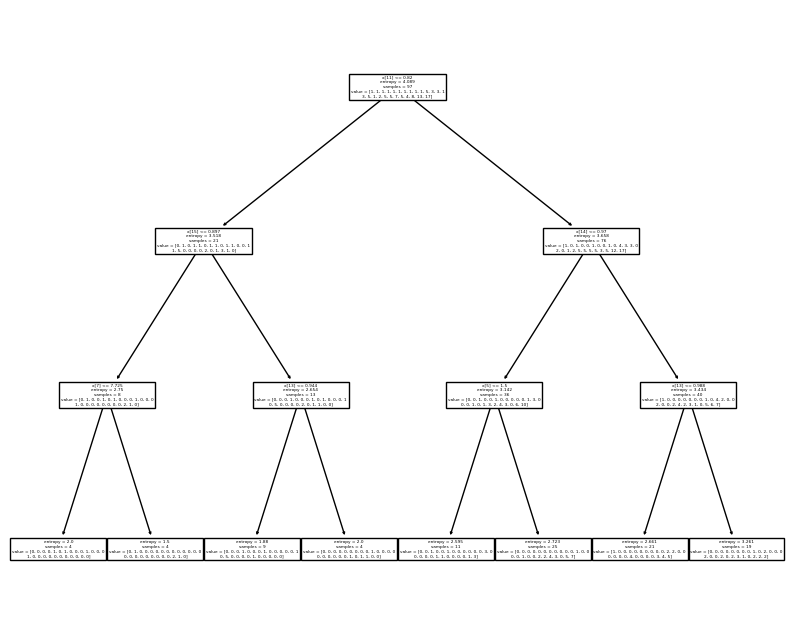

In [55]:
from sklearn.tree import plot_tree

model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=3)
model.fit(X_train_word2vec, y_train_word2vec)

plt.figure(figsize=(10, 8))
plot_tree(model)
plt.show()

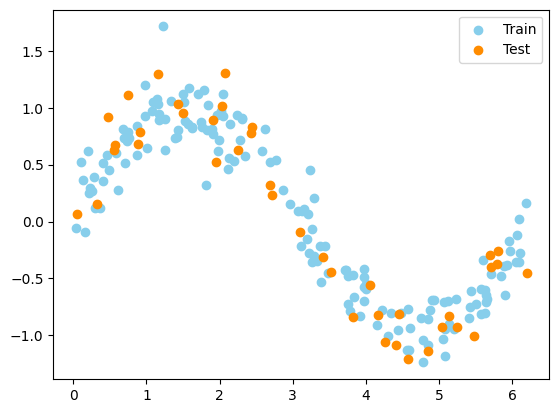

In [57]:
from sklearn.tree import DecisionTreeRegressor

# Creating a 1D dataset for regression
np.random.seed(42)
n_data = 200
X_reg = np.random.uniform(0, 2*np.pi, n_data).reshape(-1, 1)
y_reg = np.sin(X_reg.flatten()) + np.random.randn(n_data)*0.2

# Splitting data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Plotting data
plt.scatter(X_train_reg.flatten(), y_train_reg, color='skyblue', label='Train')
plt.scatter(X_test_reg.flatten(), y_test_reg, color='darkorange', label='Test')
plt.legend()
plt.show()

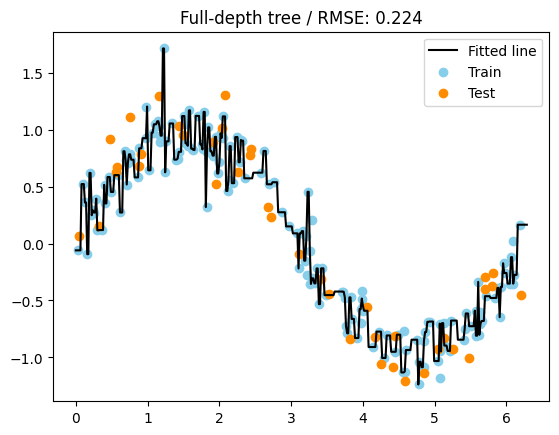

In [58]:
# Full-depth tree

# Fitting model
model = DecisionTreeRegressor(criterion='squared_error', random_state=42)
model.fit(X_train_reg, y_train_reg)

# Predicting test data
y_pred = model.predict(X_test_reg)

# Computing RMSE
error = mean_squared_error(y_test_reg, y_pred, squared=False)

# Plotting the fitted line
fitted_line_x = np.linspace(0, 2*np.pi, 400)
fitted_line_y = model.predict(fitted_line_x.reshape(-1, 1))
plt.plot(fitted_line_x, fitted_line_y, color='black', label='Fitted line')

plt.scatter(X_train_reg, y_train_reg, color='skyblue', label='Train')
plt.scatter(X_test_reg, y_test_reg, color='darkorange', label='Test')
plt.legend()
plt.title(f'Full-depth tree / RMSE: {error:.3f}')
plt.show()


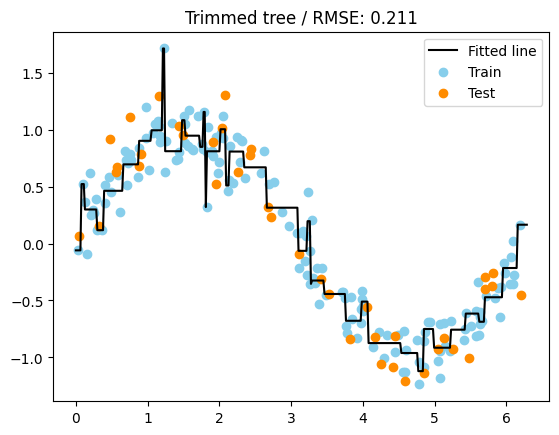

In [59]:
# Using min_samples_split

# Fitting model
model = DecisionTreeRegressor(criterion='squared_error', random_state=42, min_samples_split=8)
model.fit(X_train_reg, y_train_reg)

# Predicting test data
y_pred = model.predict(X_test_reg)

# Computing RMSE
error = mean_squared_error(y_test_reg, y_pred, squared=False)

# Plotting the fitted line
fitted_line_x = np.linspace(0, 2*np.pi, 400)
fitted_line_y = model.predict(fitted_line_x.reshape(-1, 1))
plt.plot(fitted_line_x, fitted_line_y, color='black', label='Fitted line')
plt.scatter(X_train_reg, y_train_reg, color='skyblue', label='Train')
plt.scatter(X_test_reg, y_test_reg, color='darkorange', label='Test')
plt.legend()
plt.title(f'Trimmed tree / RMSE: {error:.3f}')
plt.show()


In [60]:
# Crating an array of different values of max_depth
max_depth_arr = np.arange(1, 50)

# Now we want to evaluate the decision tree model on all these values
# We loop through all max_depth values and conduct a cross validation
# evaluation for each max_depth value

# Arrays to save the average cross-validation scores for each max_depth value
# on the train and validation data of each split
train_score_arr = []
val_score_arr = []
for max_depth in max_depth_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_score_arr = []
  fold_val_score_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_reg, y_train_reg)):
    xt = X_train_reg[train_idx]
    yt = y_train_reg[train_idx]

    xv = X_train_reg[val_idx]
    yv = y_train_reg[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    error = mean_squared_error(y_pred_train, yt, squared=False)
    fold_train_score_arr.append(error)

    # Validation
    error = mean_squared_error(y_pred_val, yv, squared=False)
    fold_val_score_arr.append(error)

  # After running all splits, we compute the avgof accuracies in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_score_arr)
  val_score_mean = np.mean(fold_val_score_arr)

  # Appending the avg/std scores of this max_depth value
  train_score_arr.append(train_score_mean)
  val_score_arr.append(val_score_mean)

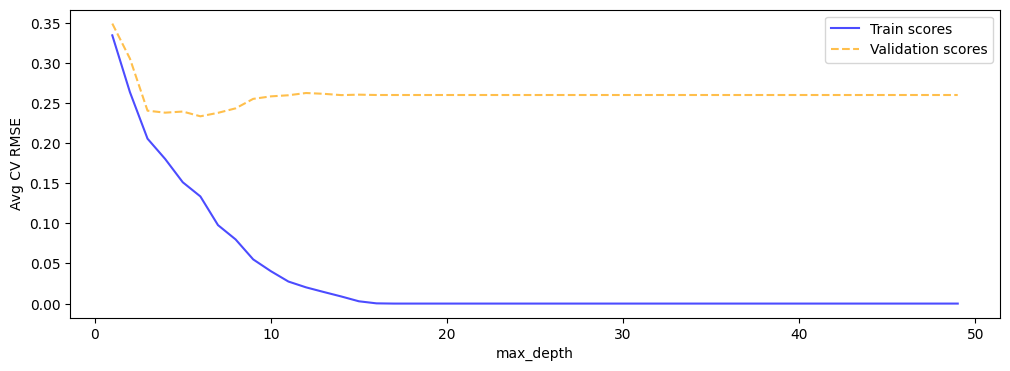

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(max_depth_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV RMSE')

plt.show()

In [62]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    criterion='entropy',
    n_estimators=200,
    max_depth=16,
    min_samples_split=10,
    random_state=42)

model.fit(X_train_word2vec, y_train_word2vec)

y_pred = model.predict(X_test_word2vec)

print(classification_report(y_test_word2vec, y_pred))

              precision    recall  f1-score   support

        48.0       0.00      0.00      0.00         1
        78.0       0.00      0.00      0.00         1
        86.0       0.00      0.00      0.00         2
        87.0       0.00      0.00      0.00         1
        88.0       0.00      0.00      0.00         1
        90.0       0.00      0.00      0.00         2
        91.0       0.00      0.00      0.00         1
        94.0       0.00      0.00      0.00         3
        95.0       0.00      0.00      0.00         1
        96.0       0.00      0.00      0.00         1
        97.0       0.00      0.00      0.00         3
        98.0       0.00      0.00      0.00         2
        99.0       0.00      0.00      0.00         1
       100.0       0.23      0.60      0.33         5

    accuracy                           0.12        25
   macro avg       0.02      0.04      0.02        25
weighted avg       0.05      0.12      0.07        25



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


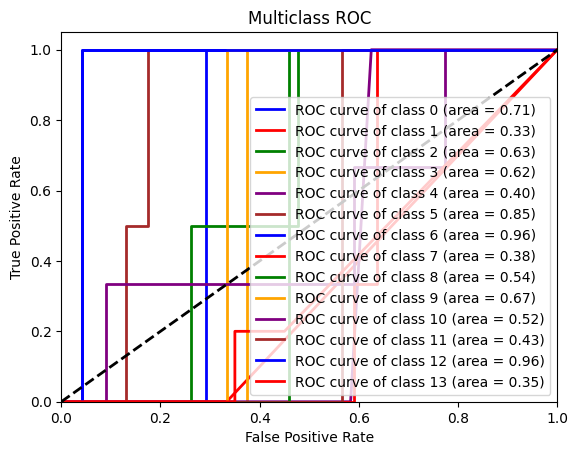

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
y_test_binarized = label_binarize(y_test_word2vec, classes=np.unique(y_test_word2vec))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()


In [68]:
# Taking one sample datapoint from the test dataset
#sample = X_test_word2vec[25].reshape(1, -1)
#print(sample)

IndexError: index 25 is out of bounds for axis 0 with size 25

In [ ]:
# Getting the random forest prediction
#print(f"Prediction: {model.predict(sample)}")

In [ ]:
# Getting the base tree predictions
"""
all_estimators = model.estimators_
all_predictions = pd.Series([tree.predict(sample)[0] for tree in all_estimators])

all_predictions.value_counts()
"""

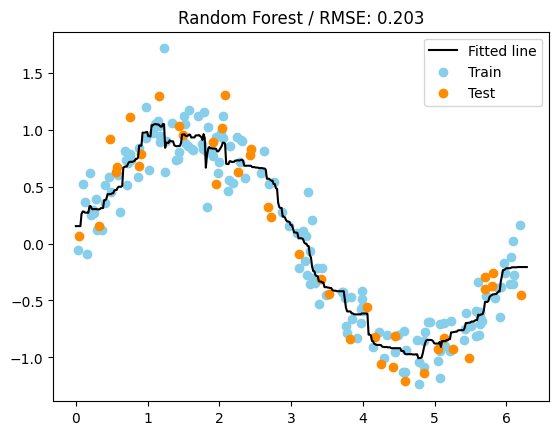

In [69]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    criterion='squared_error',
    n_estimators=200,
    max_depth=16,
    min_samples_split=10,
    random_state=42
)

model.fit(X_train_reg, y_train_reg)
y_pred = model.predict(X_test_reg)

# Computing RMSE
error = mean_squared_error(y_test_reg, y_pred, squared=False)

# Plotting the fitted line
fitted_line_x = np.linspace(0, 2*np.pi, 400)
fitted_line_y = model.predict(fitted_line_x.reshape(-1, 1))
plt.plot(fitted_line_x, fitted_line_y, color='black', label='Fitted line')
plt.scatter(X_train_reg, y_train_reg, color='skyblue', label='Train')
plt.scatter(X_test_reg, y_test_reg, color='darkorange', label='Test')
plt.legend()
plt.title(f'Random Forest / RMSE: {error:.3f}')
plt.show()

In [53]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 0.0
Node 2 has MSE 126.39409722222263
Node 3 has MSE 278.99609375
Node 4 has MSE 117.63222222222339
Node 5 has MSE 125.84000000000106
Node 6 has MSE 38.83950617284063
Node 7 has MSE 7.360000000000582
Node 8 has MSE 0.0
Node 9 has MSE 0.25
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 7.25
Node 13 has MSE 1.0
Node 14 has MSE 0.0
Node 15 has MSE 0.0
Node 16 has MSE 1.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 0.0
Node 20 has MSE 55.88750000000073
Node 21 has MSE 28.691358024692818
Node 22 has MSE 17.493333333333794
Node 23 has MSE 20.693877551020705
Node 24 has MSE 0.6875
Node 25 has MSE 0.0
Node 26 has MSE 0.25
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 0.22222222222262644
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 3.109375
Node 33 has MSE 0.23999999999978172
Node 34 has MSE 0.0
Node 35 has MSE 0.0
Node 36 has MSE 0.6666666666660603
Node 37 has MSE 0.25
Node 38 has MSE 0.0
Node 39 has MSE

In [54]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df_tf_idf.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [ ]:
# Prediction
y_train_pred = regressor.predict(X_train_tf_idf)
y_test_pred = regressor.predict(X_test_tf_idf)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train_tf_idf,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test_tf_idf,y_test_pred))

print("R2 Train:", r2_score(y_train_tf_idf,y_train_pred))
print("R2 TEST:", r2_score(y_test_tf_idf,y_test_pred))


MSE Train: 2.6184830633284246
MSE TEST: 113.04108979591837
R2 Train: 0.9839770066096497
R2 TEST: -0.0069076350718151325
